The problem number 6.9.32

Фунции нахождения разделенных разностей divided_diff и интерполяции в форме Ньютона newton_poly

Ошибка опредления населения США при экстраполяции в 2010 519160970


C:\Users\tengi\AppData\Local\Temp\ipykernel_32396\2257355365.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_new[100], y_new[100], 'ro', markersize=8, label='Экстраполированная точка(население в 2010 году в США)', color = 'black')


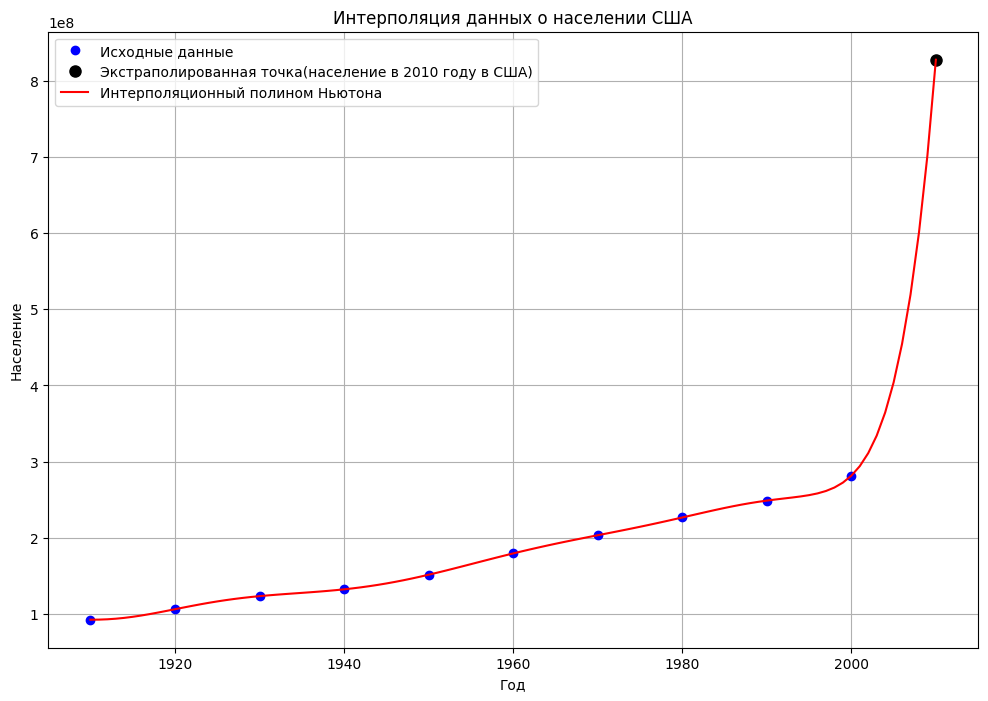

10
10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])
y = np.array([92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 
              203211926, 226545805, 248709873, 281421906])

def divided_diff(x, y):
    n = len(x)
    coef = np.zeros([n, n])
    coef[:, 0] = y 
    
    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i+1][j-1] - coef[i][j-1]) / (x[i+j] - x[i])
    
    return coef[0, :]

def newton_poly(coef, x_data, x):
    n = len(x_data) - 1
    p = coef[n]
    
    for k in range(1, n+1):
        p = coef[n-k] + (x - x_data[n-k]) * p
    
    return p
a_s = divided_diff(x, y)
x_new = np.arange(1910, 2011, 1)
y_new = newton_poly(a_s, x, x_new)
print('Ошибка опредления населения США при экстраполяции в 2010', int(y_new[100] - 308745538) - 1)

plt.figure(figsize=(12, 8))
plt.plot(x, y, 'bo', label='Исходные данные')
plt.plot(x_new[100], y_new[100], 'ro', markersize=8, label='Экстраполированная точка(население в 2010 году в США)', color = 'black')
plt.plot(x_new, y_new, 'r-', label='Интерполяционный полином Ньютона')
plt.xlabel('Год')
plt.ylabel('Население')
plt.title('Интерполяция данных о населении США')
plt.legend()
plt.grid(True)
plt.show()

Теперь вместо интерполяции одним многочленом, который сильно подстраивается под данные и возникает 'переобучение', будет строить интерполяцию сплайнами, то есть на каждом отрезке между ближайшими узлами будет строить полиномиальную интерполяцию малых степеней.

Интерполяция линейными сплайнами

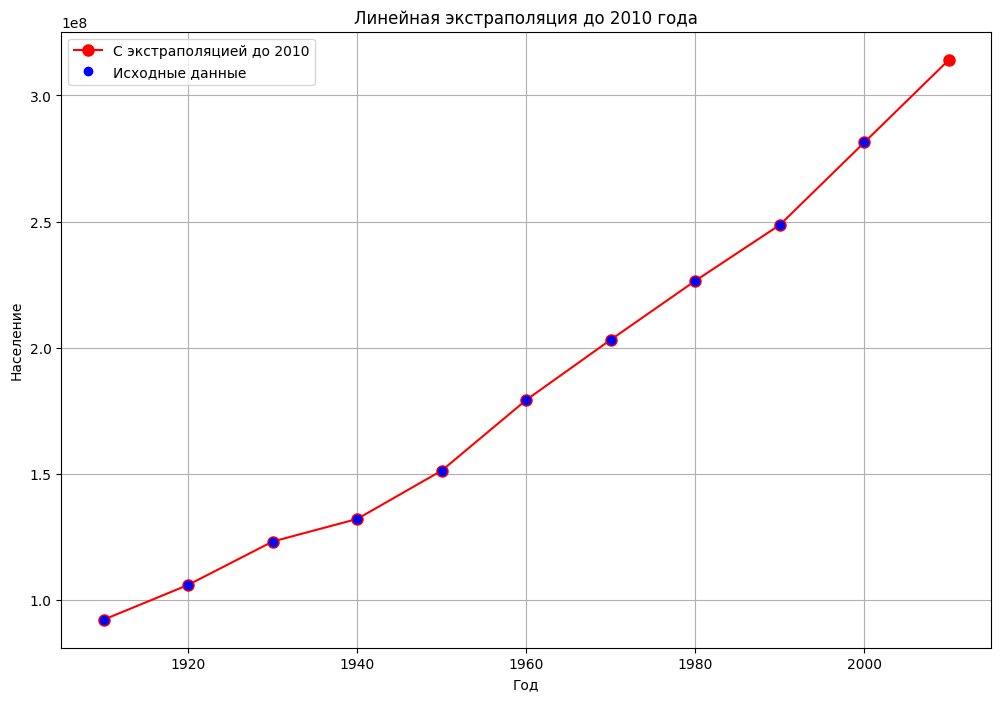

Прогноз населения на 2010 год: 314133939 человек


In [52]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])
y = np.array([92228496, 106021537, 123202624, 132164569, 151325798, 
              179323175, 203211926, 226545805, 248709873, 281421906])

x_extra = 2010
coef = (y[-1] - y[-2]) / (x[-1] - x[-2])
y_extra = y[-1] + coef * (x_extra - x[-1])

x_n = np.append(x, x_extra)
y_n = np.append(y, y_extra)

plt.figure(figsize=(12, 8))
plt.plot(x_n, y_n, 'ro-', markersize=8, label='С экстраполяцией до 2010')
plt.plot(x, y, 'bo', markersize=6, label='Исходные данные')
plt.xlabel('Год')
plt.ylabel('Население')
plt.title('Линейная экстраполяция до 2010 года')
plt.legend()
plt.grid(True)
plt.show()

print(f"Прогноз населения на 2010 год: {y_extra:.0f} человек")

Интерполяция кубическими сплайнами

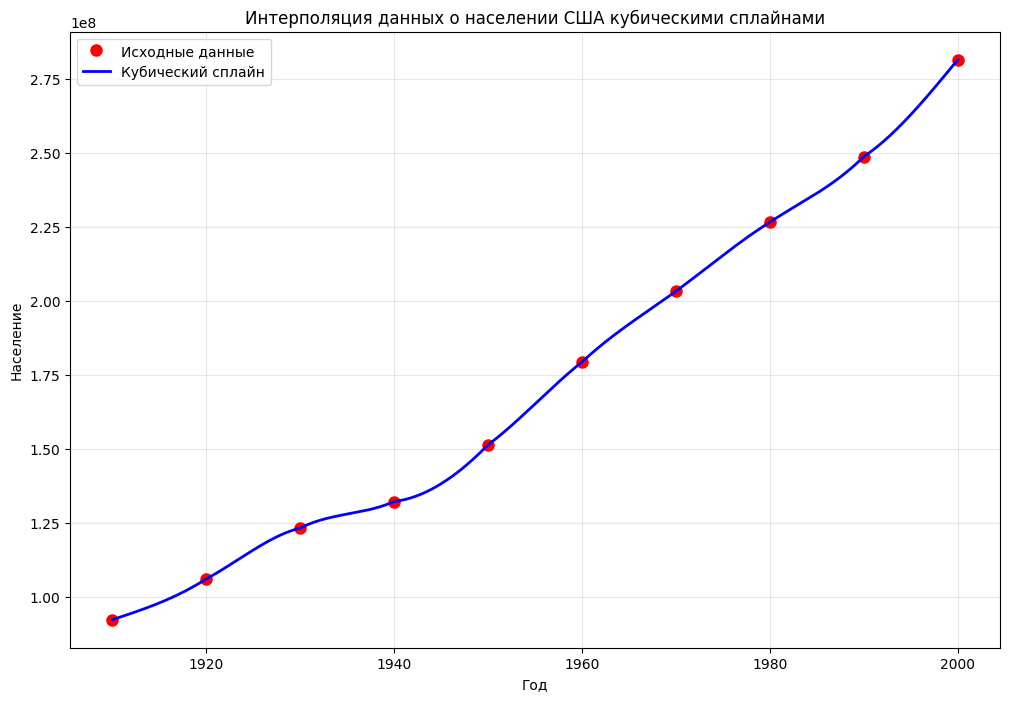

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def thomas_algorithm(h, u):
    """
    Метод прогонки для решения трёхдиагональной системы сплайнов
    """
    N = len(h)  # количество отрезков
    n_unknown = N - 1  # количество неизвестных
    
    xi = np.zeros(n_unknown)
    eta = np.zeros(n_unknown)
    c = np.zeros(N + 1)
    
    # Прямой ход
    if n_unknown >= 1:
        beta1 = 2.0
        gamma1 = h[1] / (h[0] + h[1])
        xi[0] = -gamma1 / beta1
        eta[0] = (6 * u[0]) / beta1
    
    for i in range(1, n_unknown - 1):
        alpha = h[i] / (h[i] + h[i+1])
        beta = 2.0
        gamma = h[i+1] / (h[i] + h[i+1])
        
        denominator = beta + alpha * xi[i-1]
        xi[i] = -gamma / denominator
        eta[i] = (6 * u[i] - alpha * eta[i-1]) / denominator
    
    if n_unknown >= 2:
        i = n_unknown - 1
        alpha = h[N-1] / (h[N-2] + h[N-1])
        beta = 2.0
        
        denominator = beta + alpha * xi[i-1]
        eta[i] = (6 * u[i] - alpha * eta[i-1]) / denominator
    
    # Обратный ход
    if n_unknown >= 1:
        c[N-1] = eta[n_unknown - 1]
        
        for i in range(n_unknown - 2, -1, -1):
            c[i+1] = xi[i] * c[i+2] + eta[i]
    
    # Граничные условия
    c[0] = 0.0
    c[N] = 0.0
    
    return c

def cubic_spline_coefficients(x, y):
    """
    Вычисление всех коэффициентов кубического сплайна
    """
    n = len(x)
    h = np.zeros(n - 1)
    for i in range(n - 1):
        h[i] = x[i + 1] - x[i]
    
    # Вычисление разделённых разностей второго порядка
    u = np.zeros(n - 2)
    for i in range(n - 2):
        h_prev = x[i + 1] - x[i]
        h_curr = x[i + 2] - x[i + 1]
        u[i] = ((y[i + 2] - y[i + 1]) / h_curr - (y[i + 1] - y[i]) / h_prev) / (h_prev + h_curr)

    c = thomas_algorithm(h, u)
    a = np.zeros(n - 1)
    b = np.zeros(n - 1)
    d = np.zeros(n - 1)
    
    for i in range(n - 1):
        a[i] = y[i]
        d[i] = (c[i + 1] - c[i]) / (3 * h[i])
        b[i] = (y[i + 1] - y[i]) / h[i] - (h[i] / 3) * (2 * c[i] + c[i + 1])
    
    return a, b, c[:-1], d, h

def evaluate_spline(x, y, a, b, c, d, h, x_eval):
    """
    Вычисление значения сплайна в точке x_eval
    """
    for i in range(len(x) - 1):
        if x[i] <= x_eval <= x[i + 1]:
            dx = x_eval - x[i]
            return a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
    if x_eval < x[0]:
        return y[0]
    else:
        return y[-1]

x = np.array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])
y = np.array([92228496, 106021537, 123202624, 132164569, 151325798, 
              179323175, 203211926, 226545805, 248709873, 281421906])

a, b, c, d, h = cubic_spline_coefficients(x, y)

x_fine = np.linspace(1910, 2000, 500)
y_spline = np.array([evaluate_spline(x, y, a, b, c, d, h, xi) for xi in x_fine])

plt.figure(figsize=(12, 8))
plt.plot(x, y, 'ro', markersize=8, label='Исходные данные')
plt.plot(x_fine, y_spline, 'b-', linewidth=2, label='Кубический сплайн')
plt.xlabel('Год')
plt.ylabel('Население')
plt.title('Интерполяция данных о населении США кубическими сплайнами')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()